 **MINI PROJECT**

 **Name**: Raghavan Gopalan
 <br>
 **Student ID**: 14994593

In this project, I analyze data related to the first-person tactical hero shooter video game Valorant. In particular, I am working with this dataset https://www.kaggle.com/datasets/ryanluong1/valorant-champion-tour-2021-2023-data that contains data from the tournaments organized by the game developers Riot Games in which the world's best players face off against each other. As an avid player and spectator of the game, one of my goals for a while has been to understand what are the most important factors that determine the outcome of the game- is it purely mechanical skill, or are there certain parts of the game 'underdogs' can focus on to gain an advantage? Interestingly, Valorant has excellent regional parity- unlike traditional sports like football, cricket, etc. where a few countries dominate the competition, or even in other esports like League of Legends (where China and Korea win the World Championship almost every year) and Counter Strike (where European teams excel). The top 4 teams in the 3 major tournaments every year almost always come from different parts of the world, no team has ever had a long term 'era', and no 1 player can definitively be considered the best player in the world like Michael Jordan or Lebron James. So this made me want to investigate, why is this the case? While this project is too short term to really quantify this, along with the nature of sports and games being inherently unpredictable due to both the inconsistent nature of humans and the complexity of the game, I believe it does produce some interesting results that can be built upon.   

In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import random

For the purpose of this project, I am only analyzing data from Valorant Champions Tour 2023. In 2021 and 2022, the format and level of competition was rather uneven and unregulated at the regional level, so the different levels of play being experienced by different teams would bias the results. In 2023 however, Riot Games introduced a partnership system similar to League of Legends, NHL, NBA etc. with certain fixed organizations competing in all the tournaments, ensuring that the best players compete in a closed circuit.
<br>
<br>
Therefore, when loading the data for this project, download the dataset (~76MB) from https://www.kaggle.com/datasets/ryanluong1/valorant-champion-tour-2021-2023-data and upload the files titled 'maps_scores.csv', 'overview.csv' and 'win_loss_methods_round_number.csv' under vct_2023 -> matches

In [67]:
winloss23_df = pd.read_csv('win_loss_methods_round_number.csv')
playerstatsdf = pd.read_csv('overview.csv')
mapscoresdf = pd.read_csv('maps_scores.csv')

**Brief Overview of Valorant and Specific Project Aim**
<br>
Valorant is a 5v5 first-person shooter, where each player plays as an agent of their choosing (among 24 options). Agents have 4 unique abilities that assist them in eliminating their opponents or securing the objective, along with the variety of guns available to everyone. In the competitive format, one of the teams initially starts on 'Attack', where their objective is to either eliminate the other team or plant the 'spike' in a 'site' and keep it secure till it explodes. The other team desires to eliminate the attackers before they plant the spike or defuse it before it explodes. This process repeats till one of the teams reaches 13 rounds (or wins 2 rounds in a row if the teams reach 12-12, like deuce in volleyball, badminton etc.). One detail to take note of, as it is relevant to a major component of my project is that the teams switch sides after 12 rounds i.e. the attackers become the defenders and vice versa. The game takes place on 1 of 7 maps (for example, Ascent, Haven, etc., see the dataset for the same) which have different layouts and unique features. However, I am largely considering the maps to be a non-factor and degenerate to the results, as otherwise the dataset it too stretched thin.
<br>
This project has 2 parts:
<br>
1. In part 1, I study the influence of round 1 and 13 on the outcome of a match.
2. Following this, I use the statistics of players in a game along with the difference in the rounds obtained by the 2 teams playing to determine the teams that perform the best in the metrics and their win rate in general based on it.  


**PART 1**

In Valorant, the first round of a half (round 1 and 13) are special, often called pistol rounds. Each player only has 800 credits, which allows them to buy only sidearms, not rifles or other advanced guns which are available for the rest of the game. Valorant's economy system favours winning- players gain credits for winning a round and get to keep their guns if they survive (unless it is round 13, when this resets). Therefore, winning round 1 and 13 play a crucial role, as it means building up the economy. The team that wins round 1 generally has a large advantage in round 2 simply due to the superior calibre of guns they have access to. However, in principle, this does not get out of control if teams are evenly matched, as losing teams are awarded an increasing amount of credits (loss bonus), giving them a chance to recover. Therefore, in a game between 2 teams of similar skill, the first half should end at a 6-6 or 7-5 scoreline.

In [68]:
grouped = winloss23_df.groupby(['Tournament', 'Stage','Match Type','Match Name','Map'])
dataframes = {name: group for name, group in grouped}
dflist = []
for key,df in dataframes.items():
  unique_values = df['Team'].unique()
  randno = random.uniform(0,1)
  #print(randno)
  if(randno>0.5):
    valuetokeep = unique_values[1]
  else:
    valuetokeep = unique_values[0]
  filtered_df = dflist.append(df[df['Team']==valuetokeep])

dflist12 = [df.head(12) for df in dflist]

In [69]:
match_results = {'Tournament':[],'Match':[],'Map':[], 'Team':[],'Pistol':[],'Wins': [], 'Losses': [],'One Sided':[]}
for i, df in enumerate(dflist12):

    wins = df['Outcome'].value_counts().get('Win', 0)
    losses = df['Outcome'].value_counts().get('Loss', 0)
    if(df['Outcome'].iloc[1]=='Win'):
      match_results['Pistol'].append(1)
      match_results['Tournament'].append(df['Tournament'].iloc[0])
      match_results['Match'].append(df['Match Name'].iloc[0])
      match_results['Team'].append(df['Team'].iloc[0])
      match_results['Map'].append(df['Map'].iloc[0])
    else:
      match_results['Pistol'].append(0)
      match_results['Tournament'].append(df['Tournament'].iloc[0])
      match_results['Match'].append(df['Match Name'].iloc[0])
      match_results['Team'].append(df['Team'].iloc[0])
      match_results['Map'].append(df['Map'].iloc[0])
    match_results['Wins'].append(wins)
    match_results['Losses'].append(losses)
    if(wins>=9 or losses>=9):
      match_results['One Sided'].append('One sided')
    else:
      match_results['One Sided'].append('Even')

resultsdf = pd.DataFrame(match_results)

Percentage of one sided first halves in VCT 2023: 33.6144578313253


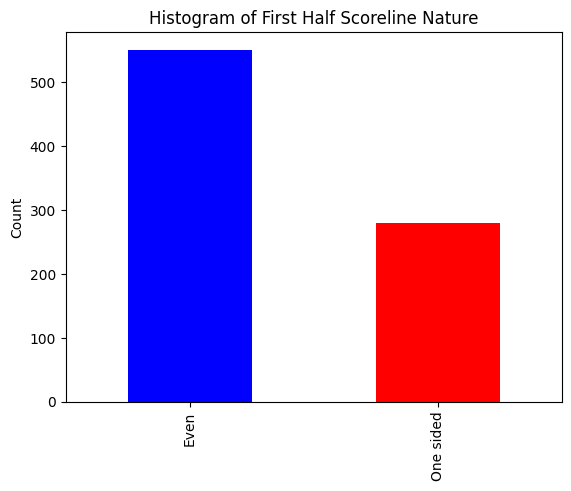

In [70]:
counts = resultsdf['One Sided'].value_counts()
print('Percentage of one sided first halves in VCT 2023:',counts[1]/(counts[0]+counts[1])*100)
counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Histogram of First Half Scoreline Nature')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

As we can see, almost 1/3 of games start with a 9-3 or higher differential scoreline. This is more than 50% when you consider 8-4 or more to be one-sided rather than 9-3. This result is despite the fact that most fans and critics of the esport agree that the teams competing are generally evenly matched, and while 'favourites' exist, upsets regularly occur.
<br>
So why does this occur? The main theory is that apart from gun economy, Valorant has an 'ultimate' economy- agents have 4 abilities, one of which is called the ultimate. While the other 3 abilities are either free or bought using credits, ultimates are earned by collecting ultimate orbs on the map, getting kills or planting/defusing the spike. And these abilties tend to be the most powerful, often having a detrimental impact on the outcome of a round. Apart from this, psychological factors also likely go into halves being quite dominant.
<br>
However, this is not what I am here to study. While it is an interesting problem, this dataset does not have information on ultimate usage and the time constraints do not allow a deep dive. Instead, I am attempting to quantify the likelihood of a team winning a match based on the outcome of the pistol rounds. With how much accuracy can we predict the likelihood of a team winning the game if they win both round 1 and 13?

In [71]:
match_results = {'Tournament':[],'Match':[],'Map':[], 'Team':[],'Pistol 1':[],'Pistol 2':[],'Map Result':[]}
for i, df in enumerate(dflist):
    match_results['Tournament'].append(df['Tournament'].iloc[0])
    match_results['Match'].append(df['Match Name'].iloc[0])
    match_results['Team'].append(df['Team'].iloc[0])
    match_results['Map'].append(df['Map'].iloc[0])
    match_results['Pistol 1'].append(df['Outcome'].iloc[0])
    match_results['Pistol 2'].append(df['Outcome'].iloc[12])
    wins = df['Outcome'].value_counts().get('Win', 0)
    losses = df['Outcome'].value_counts().get('Loss', 0)
    if(wins>losses):
      match_results['Map Result'].append('Win')
    else:
      match_results['Map Result'].append('Loss')

pistolresultsdf = pd.DataFrame(match_results) #This dataframe now has only results of round 1 and 13 along with the match details

#Numerically encoding the outcomes of rounds and maps
pistolresultsdf['Pistol 1'] = pistolresultsdf['Pistol 1'].map({'Win': 1, 'Loss': 0})
pistolresultsdf['Pistol 2'] = pistolresultsdf['Pistol 2'].map({'Win': 1, 'Loss': 0})
pistolresultsdf['Map Result'] = pistolresultsdf['Map Result'].map({'Win': 1, 'Loss': 0})

print('The final processed data being used for Part 1:')
pistolresultsdf

The final processed data being used for Part 1:


,Tournament,Match,Map,Team,Pistol 1,Pistol 2,Map Result
0,Champions Tour 2023: Americas Last Chance Qual...,KRÜ Esports vs Leviatán,Ascent,KRÜ Esports,0,1,1
1,Champions Tour 2023: Americas Last Chance Qual...,KRÜ Esports vs Leviatán,Lotus,KRÜ Esports,0,1,1
2,Champions Tour 2023: Americas Last Chance Qual...,KRÜ Esports vs Leviatán,Pearl,KRÜ Esports,0,1,0
3,Champions Tour 2023: Americas Last Chance Qual...,KRÜ Esports vs Leviatán,Split,Leviatán,0,1,0
4,Champions Tour 2023: Americas Last Chance Qual...,Cloud9 vs Leviatán,Bind,Leviatán,1,1,1
...,...,...,...,...,...,...,...
825,Valorant Champions 2023,DRX vs Evil Geniuses,Fracture,Evil Geniuses,1,0,1
826,Valorant Champions 2023,DRX vs Evil Geniuses,Lotus,Evil Geniuses,1,1,1
827,Valorant Champions 2023,LOUD vs Paper Rex,Lotus,LOUD,0,1,0
828,Valorant Champions 2023,LOUD vs Paper Rex,Pearl,Paper Rex,0,1,1


The machine learning technique I am using here is a binary classifier that takes two inputs and outputs a single probability (of the team whose pistol rounds results are being modelled wins the game). The model consists of three fully connected layers and can be expressed as:
$y = \sigma(W_3 . ReLU(W_2 . ReLU (W_1 x + b_1)+ b_2) + b_3)$
The model performs a linear transformation followed by ReLU activation, followed by another of the same, and a final linear transformation with a sigmoid activation to produce an output probability for given input vector $x = [x_1,x_2]$

In [72]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [73]:
def createdataloaders(Xdata,Ydata):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Converting to PyTorch tensors
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

  # Creating data loaders
  train_data = torch.utils.data.TensorDataset(X_train, y_train)
  test_data = torch.utils.data.TensorDataset(X_test, y_test)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

  return train_loader,test_loader,scaler

In [74]:
def pistolmodel(traindata,testdata,scaler):
  # Initialize the model, loss function, and optimizer
  model = SimpleNN()
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  #Training loop
  epochs = 500
  for epoch in range(epochs):
      model.train()
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

    #print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

  # Evaluate the model
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for inputs, targets in test_loader:
          outputs = model(inputs)
          predicted = (outputs > 0.5).float()
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total
      print(f'Model accuracy: {accuracy*100:.2f}%')
  # Create a grid of possible round results
  round_1_values = [0, 1]
  round_13_values = [0, 1]
  grid_round1, grid_round13 = np.meshgrid(round_1_values, round_13_values)
  grid_points = np.c_[grid_round1.ravel(), grid_round13.ravel()]

  # Standardize the grid points
  grid_points = scaler.transform(grid_points)

  # Convert grid points to tensor
  grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)

  # Predict probabilities using the trained model
  model.eval()
  with torch.no_grad():
      predictions = model(grid_points_tensor).numpy().reshape(grid_round1.shape)

  # Plot the heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(predictions, annot=True, cmap='viridis', cbar=True, xticklabels=round_13_values, yticklabels=round_1_values, fmt=".2f")
  plt.title('Predicted Probability of Winning the Map Based on Round 1 and Round 13 Results')
  plt.xlabel('Round 13 Result')
  plt.ylabel('Round 1 Result')
  plt.show()

Model accuracy: 62.65%


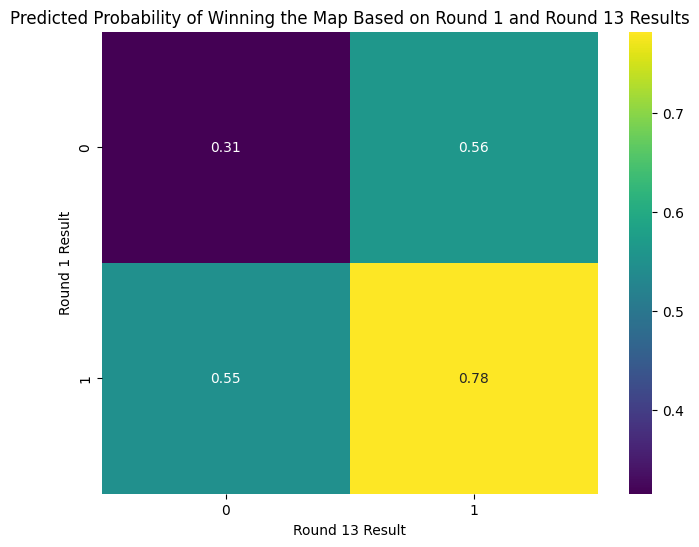

In [75]:
#Generating the arrays that will serve as test and training data
X = pistolresultsdf[['Pistol 1', 'Pistol 2']].values
y = pistolresultsdf['Map Result'].values

train_loader,test_loader,scaler = createdataloaders(X,y)
pistolmodel(train_loader,test_loader,scaler)

**RESULTS AND FUTURE RESEARCH**
<br>
The model predicts that a team has a more than 70% chance of winning a match if they win both pistol rounds, and less than 25% if they lose both. Interestingly, the order does not seem to matter too much if both teams win a pistol each. Comebacks are quite realistic. However, it is important to note that this model only has an accuracy of ~65%. This is because there is a lot of variance in the data and we would need more parameters to predict results better. The game is a lot more complex than just 2 rounds. But the nature of competition is inherently unpredictable, so even such a result is quite significant in my opinion.
<br>
These results could be used teams and fans to interpret the results of a game. Is my favourite team getting weaker, or did they merely lose both pistols (which are to some extent rng) and were unable to crawl their way back? Coaches can look at weaknesses of their team's and their opponents' pistol rounds and exploit them. It also raises an interesting question for the game developers- should one round have such a high impact on the game? This is in fact already being addressed to some extent, with many agents' ultimate abilities requiring more orbs or being made weaker.
<br>
In terms of further research, one could make more rigorous models accounting for economy management by teams, what agents are being played and their ability strengths, etc. Round 3 (and 15) results may also be interesting to look at, as the team that is 2-0 usually has weaker guns saved from the previous round, while the winless team buys the strongest weapons possible to get off the mark and stop the momentum. More definite results can be obtained with more data- I have not added this year's data as barely half the games have been played, but after a year or two, it may be interesting to see how the influence of pistol rounds evolve.
<br>


**PART 2**

In this part of the project, I aim to compare the relative strengths of teams based on their scores in games and player stats. The main statistic used here is the average combat score- a parameter that serves as a holistic measure of the damage you do in a round, kills obtained, the number of kills you assisted in getting, your role in the objective (planting/defusing the spike), etc. While not a perfect statistic, ACS generally serves as a good indicator of the impact of a player in a game.
<br>
First, I simplify the dataset by removing irrelevant columns like attacker and defender scores, since only overall game score matters to the model. I am also removing teams that played very few games, as well as China Qualifier games, as they were relatively unregulated and the competition was unbalanced. After this simplification, we have teams that played atleast 10 best of 3 games, so we have sufficient data to comment.

In [76]:
filtered_mapscores = mapscoresdf[~((mapscoresdf['Tournament'].str.contains('China Qualifier')))]
filtered_mapscores = filtered_mapscores[~((filtered_mapscores['Match Name'].str.contains('Attacking Soul')))]
filtered_mapscores = filtered_mapscores[~((filtered_mapscores['Match Name'].str.contains('Bilibili')))]
filtered_mapscores = filtered_mapscores[~((filtered_mapscores['Match Name'].str.contains('FPX')))]
filtered_mapscores = filtered_mapscores.drop(columns=['Team A Attacker Score','Team A Defender Score','Team A Overtime Score','Team B Attacker Score','Team B Defender Score','Team B Overtime Score','Duration'])

filtered_playerstats = playerstatsdf[(playerstatsdf['Side']=='both')]
filtered_playerstats = filtered_playerstats[~((filtered_playerstats['Map']=='All Maps'))]
filtered_playerstats = filtered_playerstats[~((filtered_playerstats['Tournament'].str.contains('China Qualifier')))]
filtered_playerstats = filtered_playerstats[~((filtered_playerstats['Match Name'].str.contains('Attacking Soul')))]
filtered_playerstats = filtered_playerstats[~((filtered_playerstats['Match Name'].str.contains('Bilibili')))]
filtered_playerstats = filtered_playerstats[~((filtered_playerstats['Match Name'].str.contains('FPX')))]
cols = [7,8,10,11,12,13,14,15,16,17,18,19,20]
filtered_playerstats = filtered_playerstats.drop(filtered_playerstats.columns[cols],axis=1)

playergroup = filtered_playerstats.groupby(['Tournament', 'Stage','Match Type','Match Name','Map'],sort=False)
playerdf = {name: group for name, group in playergroup}
playerdflist = []
for key,df in playerdf.items():
  playerdflist.append(df)

processed_playerdflist = []
for df in playerdflist:
  flattened_data = df.values.flatten()
  new_columns = [f'{col}_{i+1}' for i in range(len(df)) for col in df.columns]
  new_df = pd.DataFrame([flattened_data],columns=new_columns)
  columns_to_drop = [f'Tournament_{i}' for i in range(2, 11)]+[f'Stage_{i}' for i in range(2, 11)]+[f'Match Type_{i}' for i in range(2, 11)]+[f'Match Name_{i}' for i in range(2, 11)]+[f'Player_{i}' for i in range(1, 11)]+[f'Map_{i}' for i in range(2, 11)]+[f'Team_{i}' for i in range(1, 11)]#+[f'Team_{i}' for i in range(7, 11)]
  df_cleaned = new_df.drop(columns=columns_to_drop)
  processed_playerdflist.append(df_cleaned)

mergeddf = pd.concat(processed_playerdflist,ignore_index=True)

filtered_mapscores.reset_index(drop=True, inplace=True)
mergeddf.reset_index(drop=True, inplace=True)
mapscores_playerstatsdf = pd.concat((filtered_mapscores,mergeddf), axis=1)
mapscores_playerstatsdf = mapscores_playerstatsdf.drop(columns=['Tournament_1','Stage_1','Map_1','Match Type_1','Match Name_1'])
mapscores_playerstatsdf['Round_Differential_A'] = mapscores_playerstatsdf['Team A Score'] - mapscores_playerstatsdf['Team B Score']
mapscores_playerstatsdf['Round_Differential_B'] = mapscores_playerstatsdf['Team B Score'] - mapscores_playerstatsdf['Team A Score']
acscolsA=[f'Average Combat Score_{i}' for i in range (1,6)]
acscolsB=[f'Average Combat Score_{i}' for i in range (6,11)]
mapscores_playerstatsdf['ACS_TeamA'] = mapscores_playerstatsdf[acscolsA].mean(axis=1)
mapscores_playerstatsdf['ACS_TeamB'] = mapscores_playerstatsdf[acscolsB].mean(axis=1)
mapscores_playerstatsdf = mapscores_playerstatsdf.drop([29,252,380,425,428,576,577,657]) #removing nan rows (error in database)

In [77]:
mapscores_playerstatsdf

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team B,Team B Score,Average Combat Score_1,...,Average Combat Score_5,Average Combat Score_6,Average Combat Score_7,Average Combat Score_8,Average Combat Score_9,Average Combat Score_10,Round_Differential_A,Round_Differential_B,ACS_TeamA,ACS_TeamB
0,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,Team Liquid,11,Natus Vincere,13,242.0,...,125.0,179.0,179.0,223.0,170.0,178.0,-2,2,176.6,185.8
1,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Bind,Team Liquid,15,Natus Vincere,17,284.0,...,101.0,204.0,196.0,221.0,188.0,193.0,-2,2,199.8,200.4
2,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Lotus,DRX,13,LOUD,15,226.0,...,156.0,297.0,224.0,162.0,188.0,159.0,-2,2,184.0,206.0
3,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Split,DRX,13,LOUD,6,223.0,...,146.0,237.0,218.0,140.0,173.0,142.0,7,-7,215.6,182.0
4,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Ascent,DRX,13,LOUD,8,264.0,...,171.0,255.0,238.0,198.0,188.0,125.0,5,-5,215.4,200.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Ascent,LOUD,8,FNATIC,13,245.0,...,104.0,329.0,198.0,218.0,205.0,158.0,-5,5,187.2,221.6
680,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Fracture,LOUD,7,FNATIC,13,228.0,...,93.0,317.0,225.0,163.0,243.0,191.0,-6,6,183.2,227.8
681,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Split,LOUD,13,FNATIC,9,285.0,...,165.0,252.0,218.0,166.0,158.0,191.0,4,-4,199.6,197.0
682,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Lotus,LOUD,13,FNATIC,8,290.0,...,109.0,235.0,188.0,164.0,161.0,174.0,5,-5,186.2,184.4


This is the processed data for all games and teams. The last 4 columns are the main ones for modelling relative team strengths. To simplify, I am considering the ACS of the team to be the average of the ACS of the individual players, and using the difference in round scores at the end of the game as another measure of the relative strengths.
<br>
Next, to actually model the teams, I encode the team names as numbers using a label encoder.

In [78]:
label_encoder = LabelEncoder()

# Combine team names into a single array to fit the encoder
teams = mapscores_playerstatsdf['Team A'].tolist() + mapscores_playerstatsdf['Team B'].tolist()

# Fit the encoder to all unique team names
label_encoder.fit(teams)

# Transform team names in 'team_a' and 'team_b'
mapscores_playerstatsdf['Team_A_encoded'] = label_encoder.transform(mapscores_playerstatsdf['Team A'])
mapscores_playerstatsdf['Team_B_encoded'] = label_encoder.transform(mapscores_playerstatsdf['Team B'])
mapscores_playerstatsdf['score_diff'] = mapscores_playerstatsdf['ACS_TeamA'] - mapscores_playerstatsdf['ACS_TeamB']

#Storing outcome for each team based on if they have a positive or negative round differential
mapscores_playerstatsdf['Outcome_A'] = mapscores_playerstatsdf['Round_Differential_A'].apply(lambda x: 1 if x > 0 else 0)
mapscores_playerstatsdf['Outcome_B'] = mapscores_playerstatsdf['Round_Differential_B'].apply(lambda x: 1 if x > 0 else 0)

The Machine Learning technique I am using is again a binary classifier using logistic regression, with 2 inputs- the round differential and the difference in the average combat scores. The model then outputs the probability of each team winning based on their individual performances on the 2 metrics.
<br>
The model can be expressed mathematically as
<br>
$y = \sigma(w.x + b) = \frac{1}{1+e^{-{w_1 x_1+ w_2 x_2 + b}}}$
<br>
Where w_1 and w_2 are the weights, x_1 and x_2 are the input vectors (ACS difference and round diffential) and b is the bias term.  

In [79]:
# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize the model, loss function, and optimizer
model = LogisticRegressionModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X = mapscores_playerstatsdf[['Round_Differential_A','score_diff']].values
y = mapscores_playerstatsdf['Outcome_A'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [80]:
from sklearn.metrics import accuracy_score

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X).squeeze()
        predictions = (outputs >= 0.5).float()
        accuracy = accuracy_score(y, predictions)
    return accuracy

# Training the model
num_epochs = 1000
print_every = 100
for epoch in range(num_epochs):
    model.train()
    # Forward pass
    outputs = model(X_train).squeeze()
    #print(outputs)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss and accuracy at specified intervals
    if (epoch+1) % print_every == 0:
        train_accuracy = compute_accuracy(model, X_train, y_train)
        test_accuracy = compute_accuracy(model, X_test, y_test)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Final evaluation after training
final_train_accuracy = compute_accuracy(model, X_train, y_train)
final_test_accuracy = compute_accuracy(model, X_test, y_test)
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Epoch [100/1000], Loss: 0.4583, Train Accuracy: 0.8668, Test Accuracy: 0.8473
Epoch [200/1000], Loss: 0.3708, Train Accuracy: 0.9302, Test Accuracy: 0.9310
Epoch [300/1000], Loss: 0.3179, Train Accuracy: 0.9471, Test Accuracy: 0.9557
Epoch [400/1000], Loss: 0.2821, Train Accuracy: 0.9641, Test Accuracy: 0.9606
Epoch [500/1000], Loss: 0.2559, Train Accuracy: 0.9767, Test Accuracy: 0.9655
Epoch [600/1000], Loss: 0.2357, Train Accuracy: 0.9767, Test Accuracy: 0.9655
Epoch [700/1000], Loss: 0.2195, Train Accuracy: 0.9789, Test Accuracy: 0.9803
Epoch [800/1000], Loss: 0.2062, Train Accuracy: 0.9831, Test Accuracy: 0.9951
Epoch [900/1000], Loss: 0.1950, Train Accuracy: 0.9831, Test Accuracy: 0.9951
Epoch [1000/1000], Loss: 0.1854, Train Accuracy: 0.9831, Test Accuracy: 0.9951
Final Train Accuracy: 0.9831
Final Test Accuracy: 0.9951


In [81]:
# Calculate average metrics for each team
teams = pd.concat([
    mapscores_playerstatsdf[['Team_A_encoded', 'ACS_TeamA', 'Round_Differential_A']].rename(columns={'Team_A_encoded': 'team', 'ACS_TeamA': 'avg_score','Round_Differential_A':'round_diff'}),
    mapscores_playerstatsdf[['Team_B_encoded', 'ACS_TeamB', 'Round_Differential_B']].rename(columns={'Team_B_encoded': 'team', 'ACS_TeamB': 'avg_score','Round_Differential_B':'round_diff'})
])
team_stats = teams.groupby('team').mean().reset_index()

# Standardize the features
scaler = StandardScaler()
team_stats[['avg_score', 'round_diff']] = scaler.fit_transform(team_stats[['avg_score', 'round_diff']])

# Convert to PyTorch tensors
team_features = torch.tensor(team_stats[['avg_score', 'round_diff']].values, dtype=torch.float32)


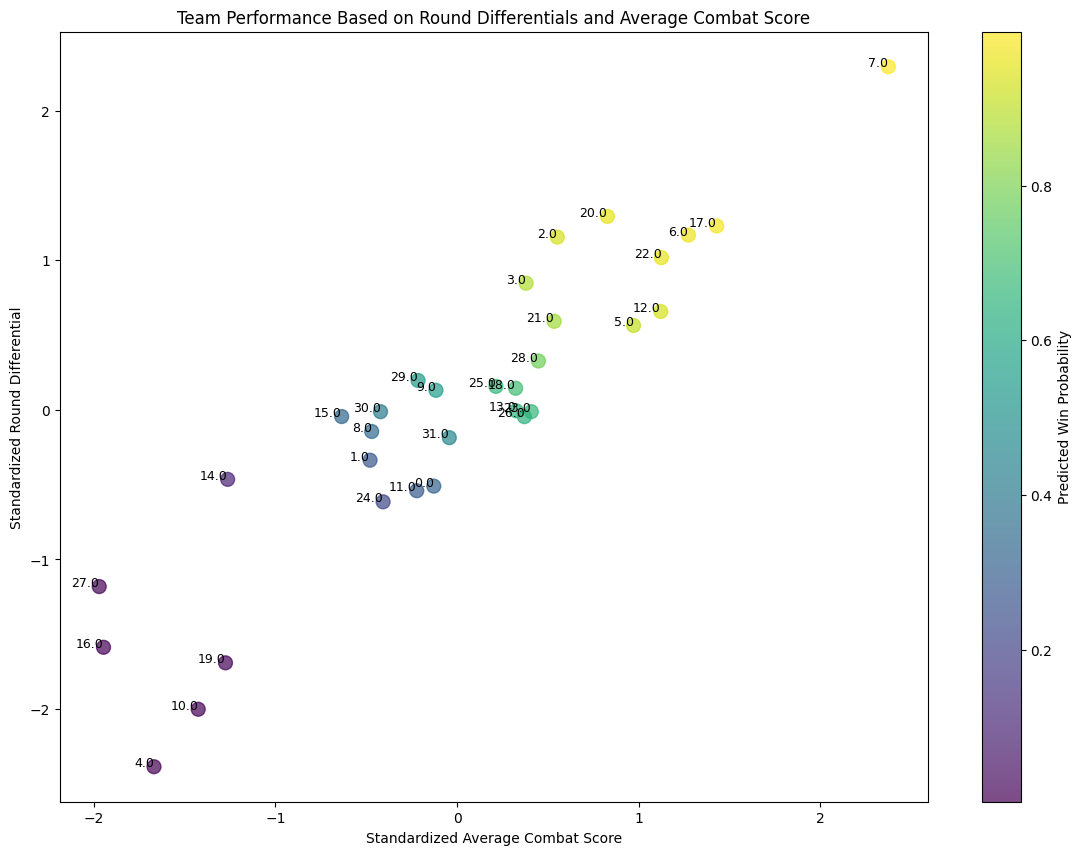

In [82]:
model.eval()
with torch.no_grad():
    win_probabilities = model(team_features).squeeze().numpy()

team_stats['win_probability'] = win_probabilities

# Visualize the results
plt.figure(figsize=(14, 10))
scatter = plt.scatter(team_stats['avg_score'], team_stats['round_diff'], c=team_stats['win_probability'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Predicted Win Probability')
for i, row in team_stats.iterrows():
    plt.text(row['avg_score'], row['round_diff'], row['team'], fontsize=9, ha='right')
plt.xlabel('Standardized Average Combat Score')
plt.ylabel('Standardized Round Differential')
plt.title('Team Performance Based on Round Differentials and Average Combat Score')
plt.show()

Use the mapping printed below along with above graph to see which teams performed the best in VCT 2023!

In [83]:
mapping = dict(zip(label_encoder.classes_, range(0, len(label_encoder.classes_)+1)))
print(mapping)

{'100 Thieves': 0, 'BBL Esports': 1, 'Cloud9': 2, 'DRX': 3, 'DetonatioN FocusMe': 4, 'EDward Gaming': 5, 'Evil Geniuses': 6, 'FNATIC': 7, 'FURIA': 8, 'FUT Esports': 9, 'FunPlus Phoenix': 10, 'Gen.G': 11, 'Giants Gaming': 12, 'Global Esports': 13, 'KOI': 14, 'KRÜ Esports': 15, 'Karmine Corp': 16, 'LOUD': 17, 'Leviatán': 18, 'MIBR': 19, 'NRG Esports': 20, 'Natus Vincere': 21, 'Paper Rex': 22, 'Rex Regum Qeon': 23, 'Sentinels': 24, 'T1': 25, 'Talon Esports': 26, 'Team Heretics': 27, 'Team Liquid': 28, 'Team Secret': 29, 'Team Vitality': 30, 'ZETA DIVISION': 31}


**RESULTS AND FUTURE RESEARCH**
<br>
We see that using ACS and round differentials actually gives us quite an accurate picture of the outcome of a game. The model has an accuracy close to 100%. In 2023, Fnatic was really the only dominant team, winning 2 of the 3 major international tournaments. This does mean that the model does not take into account recency, for Evil Geniuses, the team indexed 17 were actually the best team at the very end of the year, winning Valorant Champions. Similarly, Loud, though they did win any tournaments in the year, performed consistently in America and won many games in the first and final tournament of the year.
<br>
One important point to note is the linear trend followed- playing for statistics is not enough, one needs to play to win rounds. There are no teams that have a very high average combat score but very bad round differential or vice versa. Also, my initial assumption has been validated to a certain extent, we see that most teams are clustered around the centre, and all these teams are from different parts of the world- indicating even level of competition througout the world.
<br>
This model directly does not have any applications, however one hypothetically use individual player statistics rather than a team averaged one to determine how much of a role they play in the team. This would likely produce a model with low accuracy like part 1, but may have significant application in making team roster upgrades. However, it is important to keep in mind that ACS and round differentials do not tell the complete picture. Some players do not do a lot in terms of statistics, but play a vital role in strategy and emotional leadership. Furthermore, some teams can have the tendency to start off slow, reading their opponents over the game and peaking at the end, leading to a win but a bad round differential. We can see this kind of contrast between NRG Esports (20) and Edward Gaming (5). So this model can be made a lot more robust.